# Определение перспективного тарифа для телеком-компании

<div style="border:solid green 2px; padding: 20px">

<b>*Описание проекта*</b>

Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. 
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<b>Описание тарифов</b>

*Тариф «Смарт»*
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

    ---

_**«Мегалайн» всегда округляет *секунды до минут, а мегабайты — до гигабайт.**_

**Каждый звонок округляется отдельно:** даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Информация об исследуемых данных

<div style="border:solid green 2px; padding: 20px">

**Таблица users (информация о пользователях):**
    
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

---

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

---

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

---

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

---

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [1]:
#импортирую все библиотеки, которые могут понадобиться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from math import factorial
import statsmodels.api as sm 

In [2]:
#отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

## Знакомство с данными

Прочту все датасеты, используемые в работе. Так как проект с равной долей вероятности я буду открывать как на платформе, так и локально, а сменить путь у 5 датасетов - не то же самое, что сменить путь у одного, открывать датасеты я буду через try/except.

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
# таблица с информацией о пользователях
try:
    users = pd.read_csv('/datasets/users.csv')
except:
    users = pd.read_csv('../Downloads/users.csv')

display(users.head(10))
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


- Пропуски только в столбце с информацией о прекращении пользования тарифом, что логично, если пользователь продолжает пользоваться такрифом, информации о дате прекращения нет.
- необходимо сменить тип столбца с датами подключения и датами отказа от тарифа.

In [5]:
# таблица с информацией о звонках
try:
    calls = pd.read_csv('/datasets/calls.csv')
except:
    calls = pd.read_csv('../Downloads/calls.csv')

display(calls.head(10))
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- Пропуски отсутствуют.
- Необходимо сменить тип данных в столбце с датой.
- Пока не понятно в каких еденицах указана продолжительность звонка, определюсь в дальнейшем.


Помимо этого, условиями тарифного плана обозначено, что все звонки округляются в большую сторону до минут. Поэтому столбец duration необходимо подвергнуть обработке.

In [6]:
# устранение замечания по округлению звонков
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


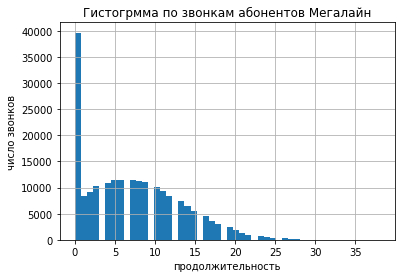

In [7]:
calls['duration'].hist(bins=50)
plt.title('Гистогрмма по звонкам абонентов Мегалайн')
plt.xlabel('продолжительность')
plt.ylabel('число звонков')
plt.show()

Вывод по гистограмме:
- очень высокий процент звонков, продолжительностью 0 минут, возможно это звонки оставшиеся без ответа.

In [8]:
# таблица с информацией о сообщениях
try:
    messages = pd.read_csv('/datasets/messages.csv')
except:
    messages = pd.read_csv('../Downloads/messages.csv')

display(messages.head(10))
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


- Пропуски отсутствуют.
- Необходимо сменить тип данных в столбце с датой.

In [9]:
try:
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
except:
    internet = pd.read_csv('../Downloads/internet.csv', index_col=0)

display(internet.head(10))
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


- Пропуски отсутствуют.
- Необходимо сменить тип данных в столбце с датой.
- Можно избавиться от столбца Unnamed: 0 так как он полностью дублирует индексы строк.
- Информация о потраченном трафике указана в Мб, так как по условию анализа известно, что оператор огругляет в сторону Гб (вообще-то нифига себе!), возможно данные в столбце нужно будет округлить.

Зафиксирую идею - возможно стоит исследовать как много переплачивает пользовватель из-за округления Мб в Гб

In [10]:
# таблица с информацией о тарифах
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('../Downloads/tariffs.csv')

display(tariffs.head(10))
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Пропусков нет.

### Обработка столбцов с указанием дат

In [11]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

display('Информация о пользователях')
display(users.info())
display('Информация о звонках')
display(calls.info())
display('Информация о сообщениях')
display(messages.info())
display('Информация об интернет сессиях')
display(internet.info())

'Информация о пользователях'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


None

'Информация о звонках'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

'Информация о сообщениях'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


None

'Информация об интернет сессиях'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


None

Тип столбцов с датами изменен. Меня вволновало как будет обработан столбец с пропусками, но и там прошло все как надо - пропуски никуда не делись, тип изменен.

Для дальнейшего анализа извлеку месяцы и года в таблицах в отдельные столбцы.

In [12]:
users['reg_month'] = users['reg_date'].dt.month
users['reg_year'] = users['reg_date'].dt.year
calls['month'] = calls['call_date'].dt.month
calls['year'] = calls['call_date'].dt.year
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

display(users.head())
display(calls.head())
display(messages.head())
display(internet.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,2018
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,2018
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,2018
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,2018


,id,call_date,duration,user_id,month,year
0,1000_0,2018-07-25,0.0,1000,7,2018
1,1000_1,2018-08-17,0.0,1000,8,2018
2,1000_2,2018-06-11,3.0,1000,6,2018
3,1000_3,2018-09-21,14.0,1000,9,2018
4,1000_4,2018-12-15,6.0,1000,12,2018


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Добавление столбцов прошло удачно. Двигаюсь дальше.

### Обработка столбцов в таблице с информацией о тарифе

Для дальнейшей работы решила сменить столбца с названием о тарифе на название, указанное в остальных датафреймах.

In [13]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

### Объем минут разговора по месяцам

Данную задачу буду решать через сводную таблицц, собранную по месяцам и пользователям, где будут отображена продолжительность звонков. Применяемыми функциями будут сумма значений и их общее число.

In [14]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()
calls_pivot

,user_id,month,sum,count
,,,duration,duration
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68


In [15]:
calls_pivot.columns

MultiIndex([('user_id',         ''),
            (  'month',         ''),
            (    'sum', 'duration'),
            (  'count', 'duration')],
           )

In [16]:
calls_pivot.columns = ['user_id', 'month', 'sum_calls', 'count_calls'] 
calls_pivot.head()

,user_id,month,sum_calls,count_calls
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


### Объем сообщений по месяцам

Для определения сообщений буду действовать так же, как и со звонками, но в функции укажу только 'count'. В качестве величины, к которой будет применена функция 'count' выбираю столбец 'id', чтобы получить количество сообщений, отправленных определенным пользователем в определенный месяц.

In [17]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count']).reset_index()
messages_pivot.head()

,user_id,month,count
,,,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [18]:
messages_pivot.columns

MultiIndex([('user_id',   ''),
            (  'month',   ''),
            (  'count', 'id')],
           )

In [19]:
messages_pivot.columns = ['user_id', 'month', 'count_mess']
messages_pivot.head()

,user_id,month,count_mess
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем интернет-трафика по месяцам

Для создания сводной таблицы проведу группировку, как и ранее, по месяцу и пользователю. В качестве величины выберу объем трафика. В данном случае буду применять только функцию суммы, чтобы посчитать общий объем трафика, используемый пользователем за определенный месяц.

In [20]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum']).reset_index()
internet_pivot.head()

,user_id,month,sum
,,,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Известно, что мобильный оператор окгруляет использованный трафик в большую сторону.  Сейчас объем трафика указан в Мб, поэтому в дальнейшем (в итоговой таблице, когда я приведу к порядку все названия столбцов) мне нужно перевести его в Гб (разделив значения за месяц на 1024), а также округлить в большую сторону, чтобы соблюсти зверские требования тарифов:)

In [21]:
internet_pivot.columns

MultiIndex([('user_id',        ''),
            (  'month',        ''),
            (    'sum', 'mb_used')],
           )

In [22]:
internet_pivot.columns = ['user_id', 'month', 'sum_trafic']
internet_pivot.head()

,user_id,month,sum_trafic
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Везде по этапу я использова .reset_index() чтобы:
- исключить вероятность потери данных при работе с merge()
- упростить переименование столбцов

### Объем выручки с пользователя по месяцам

Для дальнейшего исследования создаю общий датафрейм, влючающий в себя информацию из исследуемых датасетов.

In [23]:
df_mobil = calls_pivot.merge(messages_pivot, how='outer', on=['user_id', 'month'])
df_mobil

,user_id,month,sum_calls,count_calls,count_mess
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0
...,...,...,...,...,...
3208,1489,8,NaN,NaN,17.0
3209,1489,9,NaN,NaN,32.0
3210,1489,10,NaN,NaN,21.0
3211,1489,11,NaN,NaN,20.0


In [24]:
df_mobil = df_mobil.merge(internet_pivot, how='outer', on=['user_id', 'month'])
df_mobil = df_mobil.rename(columns={('sum', 'mb_used') : 'mb_trafic_sum'})
df_mobil

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic
0,1000,5,159.0,22.0,22.0,2253.49
1,1000,6,172.0,43.0,60.0,23233.77
2,1000,7,340.0,47.0,75.0,14003.64
3,1000,8,408.0,52.0,81.0,14055.93
4,1000,9,466.0,58.0,57.0,14568.91
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17206.30
3210,1489,10,NaN,NaN,21.0,19559.44
3211,1489,11,NaN,NaN,20.0,17491.56
3212,1489,12,NaN,NaN,35.0,17322.51


In [25]:
df_mobil = df_mobil.merge(users, how='outer', on='user_id')
df_mobil


,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year
0,1000,5.0,159.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
1,1000,6.0,172.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
2,1000,7.0,340.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
3,1000,8.0,408.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
4,1000,9.0,466.0,58.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018
3212,1489,11.0,NaN,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018
3213,1489,12.0,NaN,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,2018


In [26]:
df_mobil = df_mobil.merge(tariffs, how='outer', on='tariff')

df_mobil

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,NaN,NaN,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018,50,15360,500,550,200,3,3
3212,1489,10.0,NaN,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018,50,15360,500,550,200,3,3
3213,1489,11.0,NaN,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018,50,15360,500,550,200,3,3
3214,1489,12.0,NaN,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,2018,50,15360,500,550,200,3,3


In [27]:
df_mobil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   sum_calls              3174 non-null   float64       
 3   count_calls            3174 non-null   float64       
 4   count_mess             2717 non-null   float64       
 5   sum_trafic             3203 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff                 3216 non-null   object        
 13  reg

Так как, согласно тарифным планам, стоимость взымается на Гб-ты, то переведу все столбцы с мегабайтами в гб, разведив их значения на 1024. Столбец с использованным трафиком округлю в большую сторону.

In [28]:
df_mobil['gb_per_month_included'] = df_mobil['mb_per_month_included'] / 1024
df_mobil['sum_trafic'] = np.ceil(df_mobil['sum_trafic'] / 1024)

df_mobil.head()

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,30720,3000,1950,150,1,1,30.0


In [29]:
df_mobil = df_mobil.drop(['mb_per_month_included'], axis = 1)
df_mobil.head()

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0
1,1000,6.0,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0
2,1000,7.0,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0
3,1000,8.0,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0
4,1000,9.0,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0


Познакомнюсь с получившимся сфодным датафреймом, в том числе с точки зрения проверки пропусков.


In [31]:
df_mobil.isna().sum()

user_id                     0
month                       2
sum_calls                  42
count_calls                42
count_mess                499
sum_trafic                 13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
reg_month                   0
reg_year                    0
messages_included           0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
dtype: int64

В датафрейме есть пропущенные значения,которые можно объяснить следующим образом:
- sum_calls и count_calls - пользователи не пользовались услугами голосового вызова
- count_mess - пользователи не отправляли сообщения
- sum_trafic - пользователи не пользовались интернетом
- churn_date - пользователи не заканчивали пользоваться тарифом.

Так как данными услугами не пользовались, чтобы предотвратить ошибки при расчетах, заполню пропуски в столбцах с информацией о минутах, смс и интернет-трафике 0 (услугой не пользовались).

In [32]:
df_mobil = df_mobil.fillna({'sum_calls': 0, 'count_calls': 0, 'count_mess': 0, 'sum_trafic': 0})
df_mobil.isna().sum()

user_id                     0
month                       2
sum_calls                   0
count_calls                 0
count_mess                  0
sum_trafic                  0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
reg_month                   0
reg_year                    0
messages_included           0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
dtype: int64

In [33]:
df_mobil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   sum_calls              3216 non-null   float64       
 3   count_calls            3216 non-null   float64       
 4   count_mess             3216 non-null   float64       
 5   sum_trafic             3216 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff                 3216 non-null   object        
 13  reg

Мне не нравится столбец месяцев пользования услугами, переведу его в целочисленый формат. В остальном, мне кажется, что все прекрасно)

In [34]:
df_mobil['month'] = df_mobil['month'].astype('Int64')

Выручку внесу отдельным столбцом, который будет формироваться по результату работы функции. Функция удовлетворяет условиям, описанным в задачах проекта.

In [35]:
def month_revenue(row):
    
    # создам переменные для дальнейших вычислений
    total_calls = row['sum_calls']   # информация общем числе использованных минут звонка в месяц
    total_massages = row['count_mess']   # информация об общем числе отправленых смс
    total_internet =row['sum_trafic']   # информация о потраченном трафике в гб
    fee = row['rub_monthly_fee'] # информация о размере абонентской платы
    
    calls_revenue = 0 # переменная для выполнения расчета выручки за звонки
    massages_revenue = 0 # переменная для выполнения расчета выручки за смс
    internet_revenue = 0 # переменная для выполнения расчета выручки за трафик
    
    calls = row['sum_calls'] - row['minutes_included'] # определяю число минут сверх нормы тарифа
    if calls > 0:
        calls_revenue = calls * row['rub_per_minute'] # определяю сумму за перерасход минут
        
    
    massages = row['count_mess'] - row['messages_included'] # определяю сумму за перерасход, также как это было со звонками
    if massages > 0:
        massages_revenue = massages * row['rub_per_message']
       
    
    internet = row['sum_trafic'] - row['gb_per_month_included'] # аналагично поступаю с интернетом
    if internet > 0: 
        internet_revenue = internet * row['rub_per_gb']

        
    # определяем общую сложив суммы за перерасход с абонентской платой
    # если перерасхода нет, то складываться будут только 0 и в итоге будет лишь сумма абонентской платы
    total_revenue = fee + (calls_revenue + massages_revenue + internet_revenue)
    
    return total_revenue 

Применю функцию к исследуемому датафрейму, и добавлю возвращенные значения в создаваемый столбец.

In [36]:
df_mobil['month_revenue'] = df_mobil.apply(month_revenue, axis=1)
df_mobil.head(10)

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month_revenue
0,1000,5,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
1,1000,6,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
2,1000,7,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
3,1000,8,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
4,1000,9,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
5,1000,10,350.0,57.0,73.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
6,1000,11,338.0,43.0,58.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
7,1000,12,333.0,46.0,70.0,10.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,1000,3000,1950,150,1,1,30.0,1950.0
8,1003,8,380.0,55.0,37.0,9.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,2018,1000,3000,1950,150,1,1,30.0,1950.0
9,1003,9,961.0,134.0,91.0,13.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,2018,1000,3000,1950,150,1,1,30.0,1950.0


Вроде сработало, но проверю на как ведут строки с явным перерасходом.

In [37]:
df_mobil.query('sum_trafic > gb_per_month_included').head(10)

,user_id,month,sum_calls,count_calls,count_mess,sum_trafic,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,reg_year,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month_revenue
50,1024,11,1146.0,157.0,0.0,43.0,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10,2018,1000,3000,1950,150,1,1,30.0,3900.0
51,1024,12,949.0,136.0,0.0,36.0,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10,2018,1000,3000,1950,150,1,1,30.0,2850.0
78,1050,7,209.0,35.0,52.0,35.0,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,6,2018,1000,3000,1950,150,1,1,30.0,2700.0
97,1060,12,1233.0,184.0,52.0,43.0,46,NaT,Калуга,Яков,Рудаков,2018-11-24,ultra,11,2018,1000,3000,1950,150,1,1,30.0,3900.0
211,1124,10,1225.0,152.0,121.0,49.0,54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,9,2018,1000,3000,1950,150,1,1,30.0,4800.0
212,1124,11,1127.0,160.0,95.0,36.0,54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,9,2018,1000,3000,1950,150,1,1,30.0,2850.0
213,1124,12,1106.0,146.0,120.0,39.0,54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,9,2018,1000,3000,1950,150,1,1,30.0,3300.0
225,1126,12,614.0,84.0,3.0,33.0,71,NaT,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra,1,2018,1000,3000,1950,150,1,1,30.0,2400.0
236,1148,5,870.0,114.0,23.0,34.0,23,NaT,Тольятти,Евдокия,Киреева,2018-04-17,ultra,4,2018,1000,3000,1950,150,1,1,30.0,2550.0
237,1148,6,747.0,113.0,15.0,32.0,23,NaT,Тольятти,Евдокия,Киреева,2018-04-17,ultra,4,2018,1000,3000,1950,150,1,1,30.0,2250.0


Результаты похожи на правду. 
Например пользователь Альбин Андрианов (211 строка) в октябре превысил лимит использования интернета на 19 гб, что составляет 2850 рублей. Учитывая абонентсткую плату по тарифу в размере 1950 рублей, Альбин был вынужден заплатить 4800 рублей.

Даже по этой информации можно предположить, что пользователи предпочтут сменить мобильного оператора, ведь такие траты непомерны.

#### Исследование выручки

Ради своего собственного любопытства, и в целях повторения материала, посмотри графически, как меняются расходы на связь у пользователей разных тарифных планов.

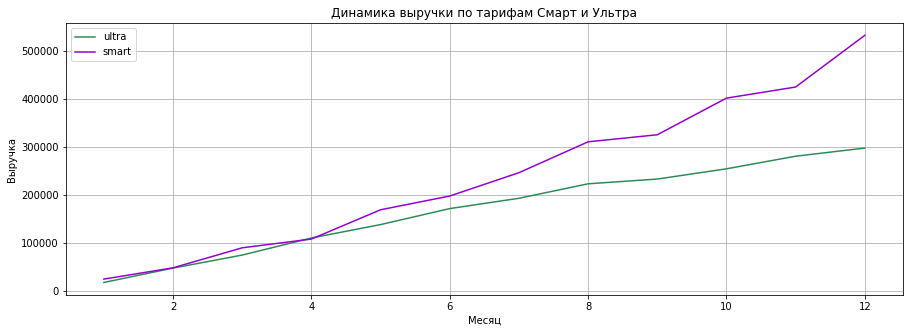

In [38]:
ax = df_mobil.query('tariff == "ultra"').groupby('month')['month_revenue'].sum().plot(x='month', y='month_revenue',
    kind='line', grid=True, color='seagreen', figsize=(15, 5), label='ultra')


df_mobil.query('tariff == "smart"').groupby('month')['month_revenue'].sum().plot(x='month', y='month_revenue',
    kind='line', grid=True, color='darkviolet', figsize=(15, 5), label='smart', ax=ax)

plt.ylabel('Выручка')
plt.xlabel('Месяц')
ax.legend()
ax.set_title('Динамика выручки по тарифам Смарт и Ультра')
plt.show()

Заметно, что в обоих случаях выручка значительно растет к декабрю. При чем несмотря на значительную разницу в абонентскийх платах, выручка по тарифу Смарт к концу года выше.

Возможно выручка растет из-за роста числа пользователей.

В первую очередь проверю сколько всего уникальных пользователей у каждого тарифа. Мне известно, что в выборке информация о 500 пользователях.

In [39]:
ultra_users = len(df_mobil[df_mobil['tariff']=='ultra']['user_id'].unique())

smart_users = len(df_mobil[df_mobil['tariff']=='smart']['user_id'].unique())

print('Всего пользователей в выборке:', ultra_users + smart_users)
print('Количество пользователей тарифа Ультра составляет:', ultra_users)
print('Количество пользователей тарифа Смарт составляет:', smart_users)

Всего пользователей в выборке: 500
Количество пользователей тарифа Ультра составляет: 149
Количество пользователей тарифа Смарт составляет: 351


В выборке пользователей тарифа Смарт свыше, чем в 2 раза больше, что может объяснять такую разницу в выручке.

Проверю как менялось число пользователей тарифа в течение 2018 года по месяцам. Сделаю это также графически.

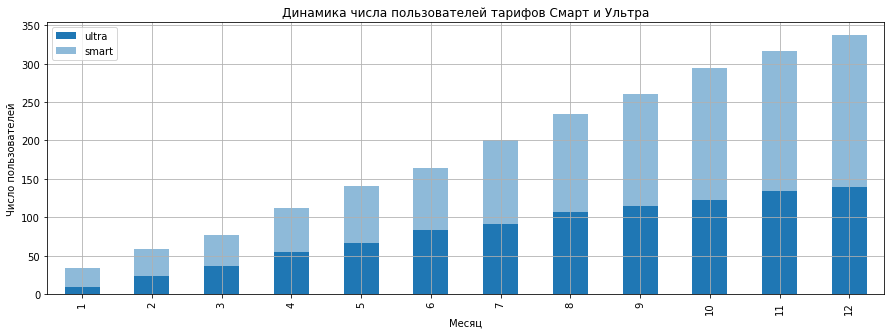

In [40]:
ax = df_mobil.query('tariff == "ultra"').groupby('month')['user_id'].count().plot(x='month', y='user_id',
    kind='bar', grid=True, figsize=(15, 5), label='ultra')

df_mobil.query('tariff == "smart"').groupby('month')['user_id'].count().plot(x='month', y='user_id',
    kind='bar', grid=True, figsize=(15, 5), label='smart', alpha = 0.5, ax=ax)

plt.ylabel('Число пользователей')
plt.xlabel('Месяц')
ax.legend()
ax.set_title('Динамика числа пользователей тарифов Смарт и Ультра')
plt.show()

Как не сложно заметить, число пользователей также растет от месяца к месяцу. При чем на графике видно, что пользователей тарифа Смарт значительно больше.

In [41]:
total_payments = len(df_mobil['month_revenue'])
print(f'Всего в таблице есть информация о {total_payments} месячных платежа в 2018 году')
df_mobil['month_revenue'].value_counts()

Всего в таблице есть информация о 3216 месячных платежа в 2018 году


1950.0    906
550.0     568
950.0      87
1150.0     80
1350.0     78
         ... 
2480.0      1
1073.0      1
888.0       1
1158.0      1
3449.0      1
Name: month_revenue, Length: 778, dtype: int64

Я располагаю информацией о 3215 платежах (здорово, ведь ровно столько строк в дф, значит я все делаю правильно), при чем из них:
- 912 платежей равны 1950 рублям
- 600 платежей равно 550 рублямя

Таким образом 1512 пользователям (чуть меньше половины) месячных лимитов достаточно. Такой себе показатель (для пользователей, не для операторов конечно).

## Анализ данных

### Общие статистические показатели

В этом разделе проекта будет представлен анализ данных, в частности:
- объем минут
- объем сообщений
- объем трафика

В исследуемом датафрейме на данный момент есть много лишних, с точки зрения анализа, столбцов, например:
- фамилия и имя пользователя
- информация о суммах за услуги и т.д.

Для дальнейшего анализа я составлю сводную таблицу только с нужными на данный момент данными.

In [42]:
df_test = df_mobil[['user_id', 'tariff', 'city', 'month', 'sum_calls', 'count_mess', 'sum_trafic', 'age', 'churn_date',
                   'reg_month', 'reg_year', 'month_revenue']]
df_test.head()

,user_id,tariff,city,month,sum_calls,count_mess,sum_trafic,age,churn_date,reg_month,reg_year,month_revenue
0,1000,ultra,Краснодар,5,159.0,22.0,3.0,52,NaT,5,2018,1950.0
1,1000,ultra,Краснодар,6,172.0,60.0,23.0,52,NaT,5,2018,1950.0
2,1000,ultra,Краснодар,7,340.0,75.0,14.0,52,NaT,5,2018,1950.0
3,1000,ultra,Краснодар,8,408.0,81.0,14.0,52,NaT,5,2018,1950.0
4,1000,ultra,Краснодар,9,466.0,57.0,15.0,52,NaT,5,2018,1950.0


In [43]:
print('Основные статистические показатели тарифа Ультра')
df_test.query('tariff == "ultra"')[['sum_calls', 'count_mess', 'sum_trafic', 'month_revenue']].describe().T

Основные статистические показатели тарифа Ультра


,count,mean,std,min,25%,50%,75%,max
sum_calls,986.0,526.089249,317.887549,0.0,282.5,518.0,751.75,1673.0
count_mess,986.0,49.313387,47.806040,0.0,6.0,38.0,78.75,224.0
sum_trafic,986.0,19.474645,9.868057,0.0,12.0,19.0,27.00,49.0
month_revenue,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.00,4800.0


#### Предварительный вывод по тарифу Ультра
<div style="border:solid black 1px; padding: 20px">

Согласно таблице в среднем пользователи тарифа Ультра в месяц:
- говорят 526 минут
- отправляют 50 смс
- используют почти 20гб интернета
- платят немного больше 2000 рублей

Медианное значение несколько отличается:
- говорят518 минут
- отправляют 38 смс
- используют 19 гб интеренета (очень близко к среднему показателю)
- платят 1950 рублей (логично, учитывая, что половина пользователей не выходит за рамки лимитов)


In [44]:
print('Основные статистические показатели тарифа Смарт')
df_test.query('tariff == "smart"')[['sum_calls', 'count_mess', 'sum_trafic', 'month_revenue']].describe().T

Основные статистические показатели тарифа Смарт


,count,mean,std,min,25%,50%,75%,max
sum_calls,2230.0,417.747534,190.476754,0.0,282.0,421.5,545.0,1435.0
count_mess,2230.0,33.369058,28.230396,0.0,10.0,28.0,51.0,143.0
sum_trafic,2230.0,16.321525,5.756167,0.0,13.0,17.0,20.0,38.0
month_revenue,2230.0,1289.641704,818.370799,550.0,550.0,1021.0,1750.0,6770.0


#### Предварительный вывод по тарифу Смарт
<div style="border:solid black 1px; padding: 20px">

Согласно таблице в среднем пользователи тарифа Смарт в месяц:
- говорят 418 минут
- отправляют 34 смс
- используют почти 17 гб интернета
- платят немного примерно 1290 рублей

Медианное значение отличается, но ближе, чем у тарифа Ультра:
- говорят 422 минут
- отправляют28 смс
- используют 17 гб интеренета 
- платят 1021 рубль (в два раза больше абонентской платы)


### Дисперсия и стандартное откроление

Так как доподленно известно, что сейчас я имею дело не с генеральной совокупностью, дисперсию я буду искать с приминением параметра ddof=1.

Прежде чем расчиатть дисперсии и ст. отклонения "вручную", воспользуюсь помощью функций. Этой таблицей я буду пользоваться, чтобы проверить все ли верно я делаю.

In [45]:
stat = df_test.pivot_table(index = ['tariff'], values = ['sum_calls', 'count_mess', 'sum_trafic', 'month_revenue'], 
                                   aggfunc=['var', 'std']).T

stat.round(0) #для удобства чтения таблицы откину знаки после запятой

tariff                smart     ultra
var count_mess        797.0    2285.0
    month_revenue  669731.0  141388.0
    sum_calls       36281.0  101052.0
    sum_trafic         33.0      97.0
std count_mess         28.0      48.0
    month_revenue     818.0     376.0
    sum_calls         190.0     318.0
    sum_trafic          6.0      10.0

In [46]:
ultra_statistic = df_test.query('tariff == "ultra"') # таблица с показателями тарифа Ультра

In [47]:
smart_statistic = df_test.query('tariff == "smart"')  # таблица с показателями тарифа Смарт

#### Дисперсия и ср. отклонение телефоной связи

In [48]:
# дисперсия для зконков тарифа Ультра
variance_ultra_calls = np.var(ultra_statistic['sum_calls'], ddof=1)
print(f'Дисперсия для телефонной связи в тарифе Ультра составляет: {variance_ultra_calls}')

# ср. отклонение для зконков тарифа Ультра
st_ultra_calls = np.sqrt(variance_ultra_calls)
print(f'Ср. отклонение для телефонной связи в тарифе Ультра составляет: {st_ultra_calls}')
print()

# дисперсия для звонков тарифа Смарт
variance_smart_calls = np.var(smart_statistic['sum_calls'], ddof=1)
print(f'Дисперсия для телефонной связи в тарифе Смарт составляет: {variance_smart_calls}')

# ср. отклонение для зконков тарифа Смарт
st_smart_calls = np.sqrt(variance_smart_calls)
print(f'Ср. отклонение для телефонной связи в тарифе Смарт составляет: {st_smart_calls}')

Дисперсия для телефонной связи в тарифе Ультра составляет: 101052.49354928387
Ср. отклонение для телефонной связи в тарифе Ультра составляет: 317.8875485911392

Дисперсия для телефонной связи в тарифе Смарт составляет: 36281.39383644458
Ср. отклонение для телефонной связи в тарифе Смарт составляет: 190.4767540579285


#### Дисперсия и ср. отклонение смс

In [49]:
# дисперсия для отправленных смс тарифа Ультра
variance_ultra_mass = np.var(ultra_statistic['count_mess'], ddof=1)
print(f'Дисперсия для отправленных смс в тарифе Ультра составляет: {variance_ultra_mass}')

# ср. отклонение для отправленных смс тарифа Ультра
st_ultra_mass = np.sqrt(variance_ultra_mass)
print(f'Ср. отклонение для отправленных смс в тарифе Ультра составляет: {st_ultra_mass}')
print()

# дисперсия для отправленных смс Смарт
variance_smart_mass = np.var(smart_statistic['count_mess'], ddof=1)
print(f'Дисперсия для отправленных смс в тарифе Смарт составляет: {variance_smart_mass}')

# ср. отклонение для отправленных смс тарифа Смарт
st_smart_mass = np.sqrt(variance_smart_mass)
print(f'Ср. отклонение для отправленных смс в тарифе Смарт составляет: {st_smart_mass}')

Дисперсия для отправленных смс в тарифе Ультра составляет: 2285.4174246558414
Ср. отклонение для отправленных смс в тарифе Ультра составляет: 47.80603962530092

Дисперсия для отправленных смс в тарифе Смарт составляет: 796.9552557301129
Ср. отклонение для отправленных смс в тарифе Смарт составляет: 28.230395954185852


#### Дисперсия и ср. отклонение интернет-трафика

In [50]:
# дисперсия для интернет-трафика тарифа Ультра
variance_ultra_trafic = np.var(ultra_statistic['sum_trafic'], ddof=1)
print(f'Дисперсия для интернет-трафика в тарифе Ультра составляет: {variance_ultra_trafic}')

# ср. отклонение для интернет-трафика тарифа Ультра
st_ultra_trafic = np.sqrt(variance_ultra_mass)
print(f'Ср. отклонение для интернет-трафика в тарифе Ультра составляет: {st_ultra_trafic}')
print()

# дисперсия для звонков интернет-трафика Смарт
variance_smart_trafic = np.var(smart_statistic['sum_trafic'], ddof=1)
print(f'Дисперсия для интернет-трафика в тарифе Смарт составляет: {variance_smart_trafic}')

# ср. отклонение для интернет-трафика тарифа Смарт
st_smart_trafic = np.sqrt(variance_smart_mass)
print(f'Ср. отклонение для интернет-трафика в тарифе Смарт составляет: {st_smart_trafic}')

Дисперсия для интернет-трафика в тарифе Ультра составляет: 97.37854429011234
Ср. отклонение для интернет-трафика в тарифе Ультра составляет: 47.80603962530092

Дисперсия для интернет-трафика в тарифе Смарт составляет: 33.133453035506285
Ср. отклонение для интернет-трафика в тарифе Смарт составляет: 28.230395954185852


Полученные значения полностью соответствуют значениям в таблице, тем, что рассчитаны функцией. Значит все в порядке.

### Графики распределения тариф Ультра

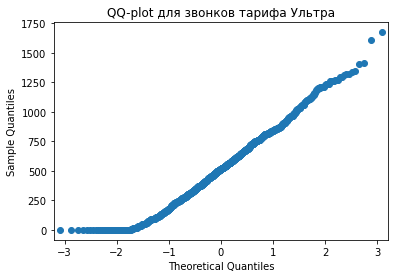

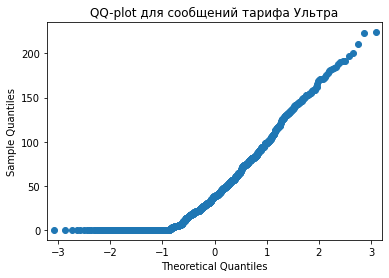

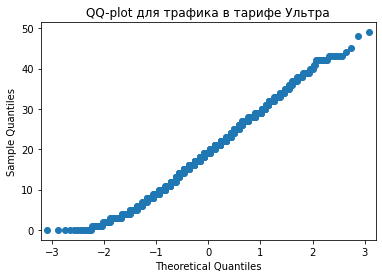

In [51]:
sm.qqplot(ultra_statistic['sum_calls']);
plt.title('QQ-plot для звонков тарифа Ультра')
plt.show()
sm.qqplot(ultra_statistic['count_mess']);
plt.title('QQ-plot для сообщений тарифа Ультра')
plt.show()
sm.qqplot(ultra_statistic['sum_trafic']);
plt.title('QQ-plot для трафика в тарифе Ультра')
plt.show()


Изучив вышерасположенные qq-плоты, очевидно и бросается в глаза, что более менее нормальным распределением обладают данные по интернет-трафику.

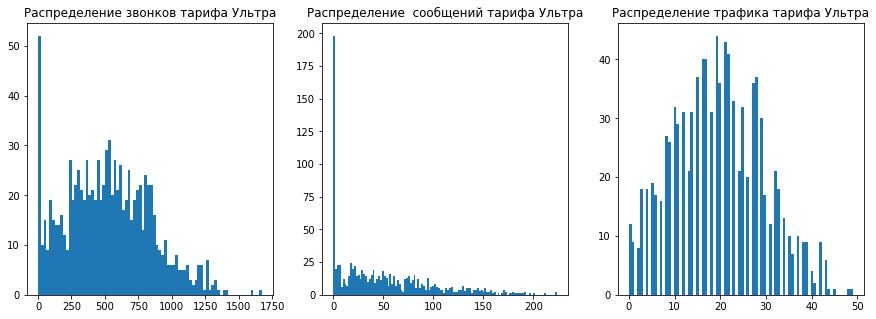

In [52]:
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1[0].hist(ultra_statistic['sum_calls'], bins=80);
ax1[0].set_title('Распределение звонков тарифа Ультра')

ax1[1].hist(ultra_statistic['count_mess'], bins=120);
ax1[1].set_title('Распределение  сообщений тарифа Ультра')

ax1[2].hist(ultra_statistic['sum_trafic'], bins=80);
ax1[2].set_title('Распределение трафика тарифа Ультра');


#### Описание графиков по тарифу Ультра

Больше всего пользователи тарифа Ультра:
- Или не пользуются телефонной связью или тратят около 500 минут в месяц.
- Не отправляю смс.
- Используют 20 гб трафика (распределение близится к нормальному)

### Графики распределения тариф Смарт

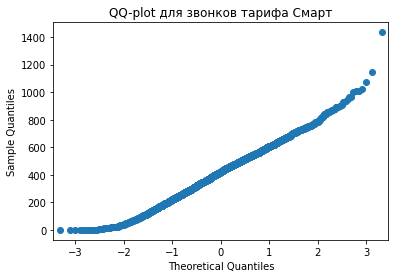

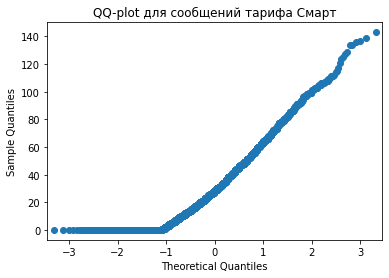

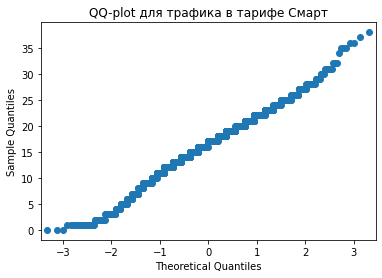

In [53]:
sm.qqplot(smart_statistic['sum_calls']);
plt.title('QQ-plot для звонков тарифа Смарт')
plt.show()
sm.qqplot(smart_statistic['count_mess']);
plt.title('QQ-plot для сообщений тарифа Смарт')
plt.show()
sm.qqplot(smart_statistic['sum_trafic']);
plt.title('QQ-plot для трафика в тарифе Смарт')
plt.show()


Здесь ситуация такая же, графиком с нормальным распределением можно назвать только тот, что построен по данным интернет трафика.

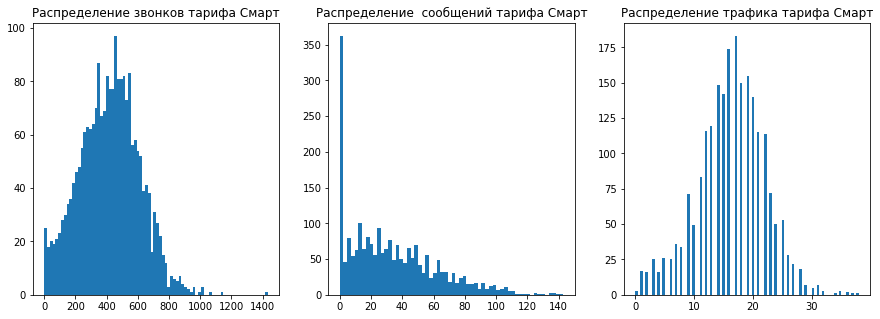

In [54]:
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1[0].hist(smart_statistic['sum_calls'], bins=80);
ax1[0].set_title('Распределение звонков тарифа Смарт')

ax1[1].hist(smart_statistic['count_mess'], bins=60);
ax1[1].set_title('Распределение  сообщений тарифа Смарт')

ax1[2].hist(smart_statistic['sum_trafic'], bins=90);
ax1[2].set_title('Распределение трафика тарифа Смарт');


#### Описание графиков по тарифу Смарт

Больше всего пользователи тарифа Смарт:
- Используют 400 минут разговора в месяц (скошенность влево)
- Не отправляю смс
- Используют 17 гб трафика (распределение близится к нормальному)

### Изучение выбросов

#### Ультра

Вышесделанные выводы говорят о том, что в даным есть выбросы. Для того, чтобы более точно ответить на вопрос какой объем услуг необходим пользователям тарифов, посмотрю что там с усами в коробках и, при необходимости, сделаю выводы, избавившишь от выбросов.

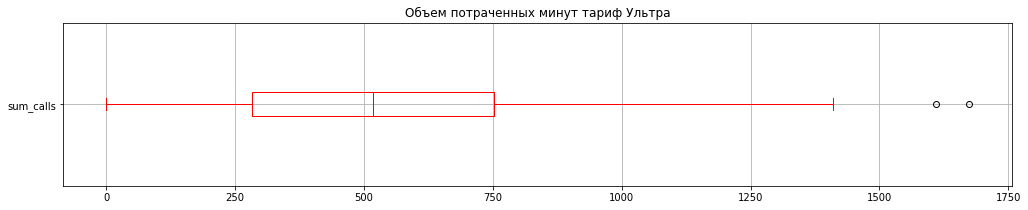

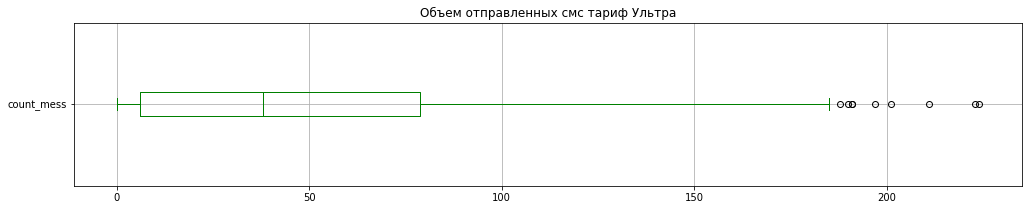

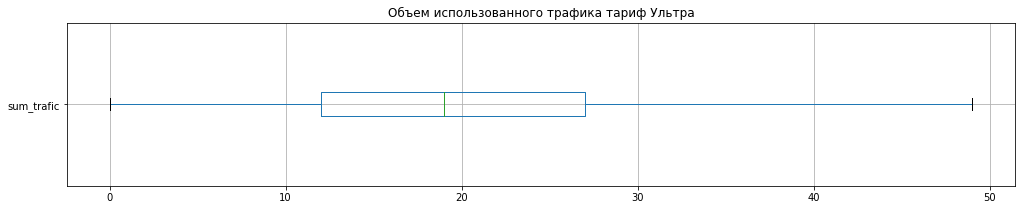

In [55]:
# использованные минуты разговора
fig, ax = plt.subplots(figsize = (17,3))
ax = ultra_statistic[['sum_calls']].boxplot(vert = False, color='red', ax =ax)
ax.set_title('Объем потраченных минут тариф Ультра')
plt.show()

# отправленные сообщения
fig, ax = plt.subplots(figsize = (17,3))
ax = ultra_statistic[['count_mess']].boxplot(vert = False, color='green', ax =ax)
ax.set_title('Объем отправленных смс тариф Ультра')


# суммарный трафик
fig, ax = plt.subplots(figsize = (17,3))
ax = ultra_statistic[['sum_trafic']].boxplot(vert = False, ax =ax)
ax.set_title('Объем использованного трафика тариф Ультра')
plt.show()

Для составления наиболее четкой картины о потребностях пользователей тарифа Ультра, избавлюсь о некоторых выбросах, а именно:
- более 1350 минут разговора (а пользователи этого тарифа любят поболтать)
- свыше 200 смс (до этого значения есть нокоторые плотные группы, поэтому буду ориентироваться именно на него)

Text(0.5, 1.0, 'Распределение  сообщений тарифа Ультра 2')

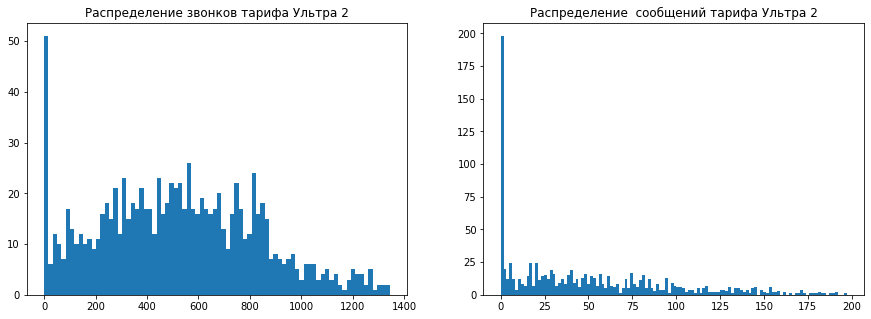

In [56]:
norm_ultra_calls = ultra_statistic.query('sum_calls <= 1350') # не "режу" одновременно, чтобы не потерять нужные данные
norm_ultra_mass = ultra_statistic.query('count_mess <= 200')

fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax1[0].hist(norm_ultra_calls['sum_calls'], bins=80);
ax1[0].set_title('Распределение звонков тарифа Ультра 2')

ax1[1].hist(norm_ultra_mass['count_mess'], bins=120);
ax1[1].set_title('Распределение  сообщений тарифа Ультра 2')

# интернет не трогаю, там выбросов нет

In [57]:
print('Данные о звонках Ультра')
display(norm_ultra_calls['sum_calls'].describe())
print('Данные о сообщениях Ультра')
display(norm_ultra_mass['count_mess'].describe())

Данные о звонках Ультра


count     982.000000
mean      522.027495
std       311.985582
min         0.000000
25%       282.000000
50%       515.500000
75%       750.750000
max      1345.000000
Name: sum_calls, dtype: float64

Данные о сообщениях Ультра


count    982.000000
mean      48.639511
std       46.715313
min        0.000000
25%        6.000000
50%       38.000000
75%       78.000000
max      197.000000
Name: count_mess, dtype: float64

Для удобства визуального восприятия соберу датафрейм со старыми и новыми значениями.

In [58]:
ultra_users_need = pd.DataFrame({'ultra': ['sum_calls', 'count_mess', 'sum_trafic'],
                                'old_mean': [526, 50, 20], 
                                'new_mean': [522, 48, 20],
                                'old_median': [518, 38, 19],
                                'new_median': [515, 38, 19],
                                'traffic_includes': [3000, 1000, 30]})
ultra_users_need

,ultra,old_mean,new_mean,old_median,new_median,traffic_includes
0,sum_calls,526,522,518,515,3000
1,count_mess,50,48,38,38,1000
2,sum_trafic,20,20,19,19,30


#### Рекомендации по тарифу Ультра

<div style="border:solid black 1px; padding: 20px">

Сразу отмечу, что рассчеты фактически не изменились, значит выбросы не имели особого влияния.

Среднестатистическому пользователю тарифа Ультра необходимо:
- Около 520 минут разговора в месяц
- Около 40-50 отправляемых смс
- 20 гб трафика


Средние и медианные значения значительно ниже того, что предлагает тариф. 

Рекомендации такие:
- оптимизации издержек оператора, можно сократить объем предоставляемых в тарифе минут и сообщений
- можно дать право выбора пользователю и, сохранив размер абонентской платы, перераспределить дефолтные пакеты услуг
- снизить абонентскую плату в качестве разовой промо-акции для привлечения новых клиентов, так как, учитывая объем, потребляемых услуг, оператор не должен понести издержки, но возможен клиентский приток.

#### Смарт

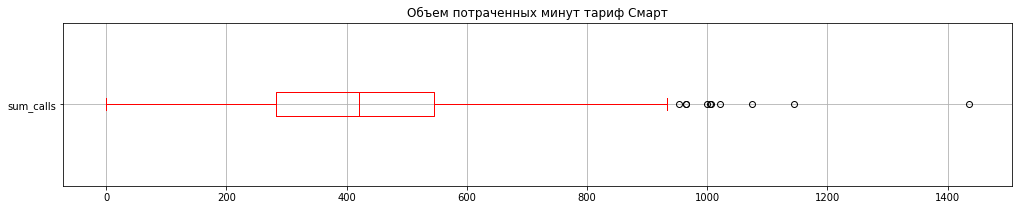

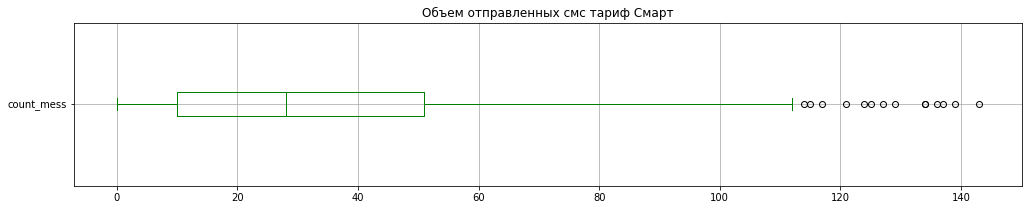

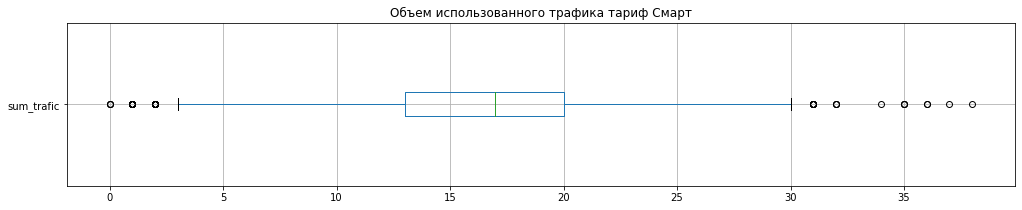

In [59]:
# использованные минуты разговора
fig, ax = plt.subplots(figsize = (17,3))
ax = smart_statistic[['sum_calls']].boxplot(vert = False, color='red',  ax =ax)
ax.set_title('Объем потраченных минут тариф Смарт')
plt.show()

# отправленные сообщения
fig, ax = plt.subplots(figsize = (17,3))
ax = smart_statistic[['count_mess']].boxplot(vert = False, color='green', ax =ax)
ax.set_title('Объем отправленных смс тариф Смарт')


# суммарный трафик
fig, ax = plt.subplots(figsize = (17,3))
ax = smart_statistic[['sum_trafic']].boxplot(vert = False, ax =ax)
ax.set_title('Объем использованного трафика тариф Смарт')
plt.show()


Что сразу бросается в глаза так это боксплот по данным о интернет трафике - медианное значение раввноудатено от границ квартилей, что, очевидно, говорит о самом, что ни на есть нормальном распределении.

Для определения потребностей пользователей тарифа Смарт я немного "порежу" выбросы, а именно:
- более 1200 минут разговора (до этого значения еще есть уплотненные группы)
- более 140 смс 
- менее 3 и более 35 гб (35 гб беру интуитивно, все-таки это не так много, если, например, пользователь ежедневно случает музыку в стриминговых сервисах типа Яндекс.музыки, которые активно "едят" трафик.

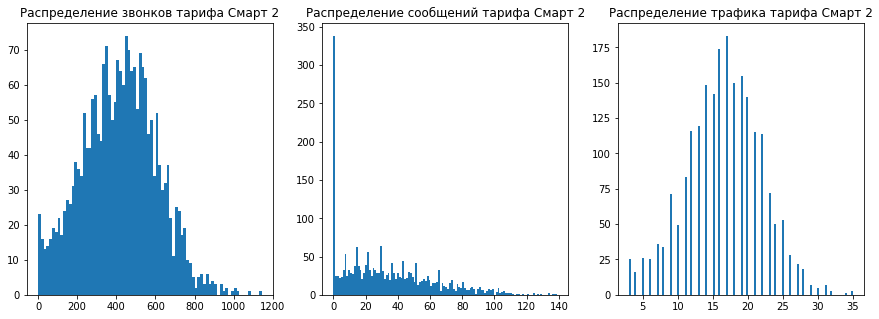

In [60]:
# не "режу" одновременно, чтобы не потерять нужные данные

norm_smart_calls = smart_statistic.query('sum_calls <= 1200') 
norm_smart_mass = smart_statistic.query('count_mess <= 140')
norm_smart_trafic = smart_statistic.query('3 <= sum_trafic <= 35')

fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1[0].hist(norm_smart_calls['sum_calls'], bins=80);
ax1[0].set_title('Распределение звонков тарифа Смарт 2')

ax1[1].hist(norm_smart_mass['count_mess'], bins=120);
ax1[1].set_title('Распределение сообщений тарифа Смарт 2')

ax1[2].hist(norm_smart_trafic['sum_trafic'], bins=120);
ax1[2].set_title('Распределение трафика тарифа Смарт 2');

Графики несколько изменились, а график по трафику стал почти эталонно нормально-распределенным. Посмотрю рассчеты и так же как и с ультра соберу датафрейм для более комфортного визуального восприятия.

In [61]:
print('Данные о звонках Смарт')
display(norm_smart_calls['sum_calls'].describe())
print('Данные о сообщениях Смарт')
display(norm_smart_mass['count_mess'].describe())
print('Данные о трафике Смарт')
display(norm_smart_trafic['sum_trafic'].describe())

Данные о звонках Смарт


count    2229.000000
mean      417.291162
std       189.296107
min         0.000000
25%       282.000000
50%       421.000000
75%       545.000000
max      1144.000000
Name: sum_calls, dtype: float64

Данные о сообщениях Смарт


count    2229.000000
mean       33.319874
std        28.141003
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       139.000000
Name: count_mess, dtype: float64

Данные о трафике Смарт


count    2190.000000
mean       16.530137
std         5.407789
min         3.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        35.000000
Name: sum_trafic, dtype: float64

In [62]:
smart_users_need = pd.DataFrame({'smart': ['sum_calls', 'count_mess', 'sum_trafic'],
                                'old_mean': [418, 34, 17], 
                                'new_mean': [417, 33, 17],
                                'old_median': [422, 28, 17],
                                'new_median': [421, 28, 17],
                                'traffic_includes': [500, 50, 15]})
smart_users_need 

,smart,old_mean,new_mean,old_median,new_median,traffic_includes
0,sum_calls,418,417,422,421,500
1,count_mess,34,33,28,28,50
2,sum_trafic,17,17,17,17,15


Избавление от выбросов не повлияло ровным счетом ни на что:)

#### Рекомендации по тарифу Смарт
<div style="border:solid black 1px; padding: 20px">

Среднестатистический пользователь тарифа:
- использует около 420 минут разговора
- отправляет олоко 30 смс
- использует 17 гб трафика ежемесячно (выше предложения тарифа).

Вероятнее всего этот тариф выбирался пользователями из-за более низкой стоимости, однако за счет интернета выпадает высокая переплата (часто выше абонетской платы, о чем говорит ранее полученные расчеты по выручке - среднее и медианное значания почти в 2 раза выше абонентской платы), поэтому:
- в целях сохранения клиентов необходимо переспотреть объем предлагаемого интернет трафика в тарифном плане или стоимость за превышение.

## Проверка гипотез

### Гипотеза 1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза обычно формируется от равенства, поэтому гипотезы будут звучать следующим образом:

Н₀(*нулевая гипотеза*) - Средние выручки пользователей тарифов «Ультра» и «Смарт» равны.

Н₁(*альтернативная гипотеза*) - Средние выручки пользователей тарифов «Ультра» и «Смарт» различаются

Я работаю с выборкой, где значительно больше 30 значений, значит распределение Стьюдента будет стремиться к нормальному, поэтому, как было рекомендованно в тренажере, не буду усложнять себе жизнь и использую Т-тест.

Помимо этого я работаю с выборками из двух генеральных совокупностей (это явно выборка, так как 500 клиентов маловато для мобильного оператора, работающего по всей стране), я буду работать методом scipy.stats.ttest_ind

Критический уровень alpha возьму за 5% (0.05).

In [63]:
ultra_revenue = ultra_statistic['month_revenue'] # данные о выручке тарифа Ультра
smart_revenue = smart_statistic['month_revenue'] # данные о выручке тарифа Смарт

alpha = .05 # критические уровень значимости

results = st.ttest_ind(
    ultra_revenue,
    smart_revenue,
    equal_var=False) # использую значение equal_var=False, что предполагает неравные дисперсии, как и в моих расчетах
                     # помимо этого число клиентов разное, стало быть и выборки не равны

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


In [64]:
print(ultra_statistic['month_revenue'].mean())
print(smart_statistic['month_revenue'].mean())

2070.030425963489
1289.6417040358745


#### Вывод

<div style="border:solid black 1px; padding: 20px">

Значени числа p-value говорит о том, что с высокой долей вероятности при случайной выборке среднее значение выручки тарифа Ультра будет отличным от средней выручки тарифа Смарт. Это позволяет нам опровергнуть нулевую гипотезу о их равенстве.
Средние выручки тарифов Смарт и Ультра различаются.

### Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Гипотезы выстраиваю отталкиваясь от равенства:

Н₀(нулевая гипотеза) - Средняя выручка пользователей из Москвы *равна* средней выручке пользователей из других регионов.

Н₁(альтернативная гипотеза) - Средняя выручка пользователей из Москвы *отличается* от выручки пользователей из других регионов.

Критический уровень alpha возьму за 5% (0.05).

В первую очередь хочу проверить на сколько различаются выборки.

In [65]:
moscow_users = df_test.query('city == "Москва"')
other_users = df_test.query('city != "Москва"')

moscow_var = np.var(moscow_users['month_revenue'], ddof=1)
other_var = np.var(other_users['month_revenue'], ddof=1)

print(f'Данных о пользователях из Москвы {len(moscow_users)}')
print(f'Данных о пользователях из других городов {len(other_users)}')
print(f'Дисперсия данных о пользователях из Москвы равна {moscow_var}')
print(f'Дисперсия данных о пользователях из других городов равна {other_var}')

Данных о пользователях из Москвы 611
Данных о пользователях из других городов 2605
Дисперсия данных о пользователях из Москвы равна 565636.467011886
Дисперсия данных о пользователях из других городов равна 654069.574962777


Число имеющихся значений неравное. Дисперсии неравны. Как и ранее я буду использовать Т-тест с указанием equal_var=False

In [66]:
moscow_revenue = moscow_users['month_revenue'] # данные о выручке от пользователей из Москвы
other_revenue = other_users['month_revenue'] # данные о выручке от пользователей из других городов

alpha = .05 # критические уровень значимости

results_2 = st.ttest_ind(
    moscow_revenue,
    other_revenue,
    equal_var=False)

print('p-значение:', results_2.pvalue)

if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


#### Вывод

<div style="border:solid black 1px; padding: 20px">

P-значение говорит о том, что есть вероятност порядка 52%, что средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других городов. Такая вероятность не позволяет наверняка опровергнуть нулевую гипотезу.

### Гипотеза 3 - средний интернет-трафик пользователей из Москвы отличается от среднего трафика пользователей из других городов


Н₀(нулевая гипотеза) - Средний интернет-трафик пользователей из Москвы равен среднему трафику пользователей из других городов.

Н₁(альтернативная гипотеза) - Средняя выручка пользователей из Москвы меньше, чем среднего трафика пользователей из других городов.


Я уже знаю, что выборки неравы, пользователей из Москвы значительно меньше.

Посчитаю дисперсию по интеренет-трафику.

In [67]:
moscow_var_trafic = np.var(moscow_users['sum_trafic'], ddof=1)
other_var_trafic = np.var(other_users['sum_trafic'], ddof=1)
print(f'Дисперсия данных о трафике пользователей из Москвы равна {moscow_var_trafic}')
print(f'Дисперсия данных о трафике пользователей из других городов равна {other_var_trafic}')

Дисперсия данных о трафике пользователей из Москвы равна 58.458077325534596
Дисперсия данных о трафике пользователей из других городов равна 53.94463117424543


Дисперсии неравны. Попробую провести односторонний тест влево (с использованием st.ttest_1samp) - среднее значение интернет-трафика пользователей из Москвы выше, чем у пользователей из других городов.

In [68]:
moscow_trafic = moscow_users['sum_trafic'] # данные о трафике пользователей из Москвы
other_trafic = other_users['sum_trafic'] # данные о трафике пользователей из других городов

alpha = .05 # критические уровень значимости

other_trafic_mean = other_trafic.mean() # средний трафик пользователей из других городов

results_3 = st.ttest_1samp(moscow_trafic, other_trafic_mean)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results_3.pvalue / 2)

# тест односторонний вправо:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if ((results_3.pvalue / 2) < alpha) and (moscow_trafic.mean() > other_trafic_mean):
    print("Отвергаем нулевую гипотезу, средний трафик пользователей из Москвы выше, чем трафик пользователей из других городов")
else:
    print("Не отвергаем нулевую гипотезу")  

p-значение: 0.0012204423159808664
Отвергаем нулевую гипотезу, средний трафик пользователей из Москвы выше, чем трафик пользователей из других городов


In [69]:
display(moscow_trafic.mean()) # средний трафик москвичей
other_trafic_mean 

18.050736497545007

17.10940499040307

И правда, повыше:)

#### Вывод
<div style="border:solid black 1px; padding: 20px">

Шалость с тестами удалась, и получилось опровергнуть гипотезу, что трафик в Москве равен трафику в регионах - разница незначительная, но она, все же, есть.

## Общие выводы по исследованию

<div style="border:solid green 2px; padding: 20px">

**Выручка**
- оба тарифа имеют одинаковую среднюю выручку
- средняя выручка не меняется в зависимости от региона
- московские пользователи в среднем используют больше гб трафика

**Рекомендации по тарифам**

*Ультра*
- можно сократить объем предоставляемых в тарифе минут и сообщений
- сохранив размер абонентской платы, перераспределить дефолтные пакеты услуг по желанию пользователя в зависимости от индивидуальных нужд
- снизить абонентскую плату в качестве разовой промо-акции для привлечения новых клиентов, так как, учитывая объем, потребляемых услуг, оператор не должен понести издержки, но возможен клиентский приток.

*Смарт*
- *обязательно* пересмотреть размер Гб в пакете услуг в большую сторону, тариф не удовлетворяет нужды пользователей.

*Какой тафир рекламировать*
- Рекламную компанию направить на тариф "Ультра", так как у тарифа "Смарт" слишком высокий уровень переплаты, что может снизить клиентскую лояльность. Помимо этого, средняя выручка по тарифу "Ультра". 